In [1]:
using DrWatson

@quickactivate

In [2]:
using HDF5
using Printf
using CairoMakie
using SparseArrays
using LinearAlgebra
using Statistics


In [3]:
using QuantumToolbox


# Exact Diagonalization

In [4]:
N = 3 # local hilbert space dimension
L = 6 # size of the chain
ω = 2.5 # frequency of the harmonic oscillator
J = 2.0 # hopping
γ = 1.0 # damping rate
U = 0.1 # Kerr non-linearity
F = 1.5 # Pump strength
maxt = 15.0 # maximum time
tlist = range(0, maxt, 200) # time list for exact diago

0.0:0.07537688442211055:15.0

In [5]:
# annihilation operator list
aj_list = []
a = destroy(N) # annihilation operator

# make sure we are type stable
sparseId = SparseMatrixCSC(Diagonal{ComplexF64}(ones(N)))
Id = QuantumObject(sparseId)
# Create the annihilation opeartors at each lattice site
for i in range(1,L)
    local_list = fill(Id,L)
    local_list[i] = a
    # annihilation acting on j
    push!(aj_list,tensor(local_list ...));
end

# create the hamiltonian

H = ω*aj_list[1]' * aj_list[1] + 0.5*U*aj_list[1]'*aj_list[1]'*aj_list[1]*aj_list[1] + F*(aj_list[1]' + aj_list[1])

for i in range(2,L)
    H+= ω*aj_list[i]' * aj_list[i] + 0.5*U*aj_list[i]'*aj_list[i]'*aj_list[i]*aj_list[i]  + J* (aj_list[i-1]' * aj_list[i]+ aj_list[i]' * aj_list[i-1])
end

In [6]:
# vaccuum state
s_list = fill(fock(N,0),L)

ψ0 = tensor(s_list...); # initial state

# dissipation only at last site
c_ops = sqrt(γ) .* aj_list
#c_ops = sqrt(γ) .* aj_list
e_ops = [aj_list[1]' * aj_list[1], aj_list[end]' * aj_list[end]]

result = mesolve(H, ψ0, tlist, c_ops, e_ops = e_ops)

Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 09s (ETA: 0h 00m 00s)


Solution of time evolution
(return code: Success)
--------------------------
num_states = 1
num_expect = 2
ODE alg.: OrdinaryDiffEqTsit5.Tsit5{typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!), Static.False}(OrdinaryDiffEqCore.trivial_limiter!, OrdinaryDiffEqCore.trivial_limiter!, static(false))
abstol = 1.0e-8
reltol = 1.0e-6


# Compare to TN data

In [7]:
function read_tn_data(File_name)
    meta_data =  Dict()

    fidr = h5open(File_name, "r")
    # load parameters
        for name in keys(fidr["metadata"])
            meta_data[name] = read(fidr["metadata"][name])
        end
    # load results
    occupations = read(fidr["results"]["occupations"])
    entropies = read(fidr["results"]["entropy_first_to_half"])
    bond_dims = read(fidr["results"]["bond_dimension"])
    correlations = read(fidr["results"]["twobody_correlation"])
    a_ops = read(fidr["results"]["annihilation_expectation"])

    close(fidr)

    return meta_data, occupations, entropies, bond_dims, correlations, a_ops

end

read_tn_data (generic function with 1 method)

In [12]:
data_route = "../data/sims/benchmark/"

file_list = readdir(data_route)

7-element Vector{String}:
 ".DS_Store"
 "TEBD_N3_L6_om2.50_J2.00_gamma1." ⋯ 32 bytes ⋯ "deltat0.06_traj100_cutexp-18.h5"
 "TEBD_N3_L6_om2.50_J2.00_gamma1." ⋯ 32 bytes ⋯ "deltat0.06_traj100_cutexp-20.h5"
 "TEBD_N3_L6_om2.50_J2.00_gamma1." ⋯ 32 bytes ⋯ "deltat0.10_traj100_cutexp-18.h5"
 "TEBD_N3_L6_om2.50_J2.00_gamma1." ⋯ 32 bytes ⋯ "deltat0.10_traj100_cutexp-20.h5"
 "TEBD_N3_L6_om2.50_J2.00_gamma1." ⋯ 32 bytes ⋯ "deltat0.20_traj100_cutexp-18.h5"
 "TEBD_N3_L6_om2.50_J2.00_gamma1." ⋯ 32 bytes ⋯ "deltat0.20_traj100_cutexp-20.h5"

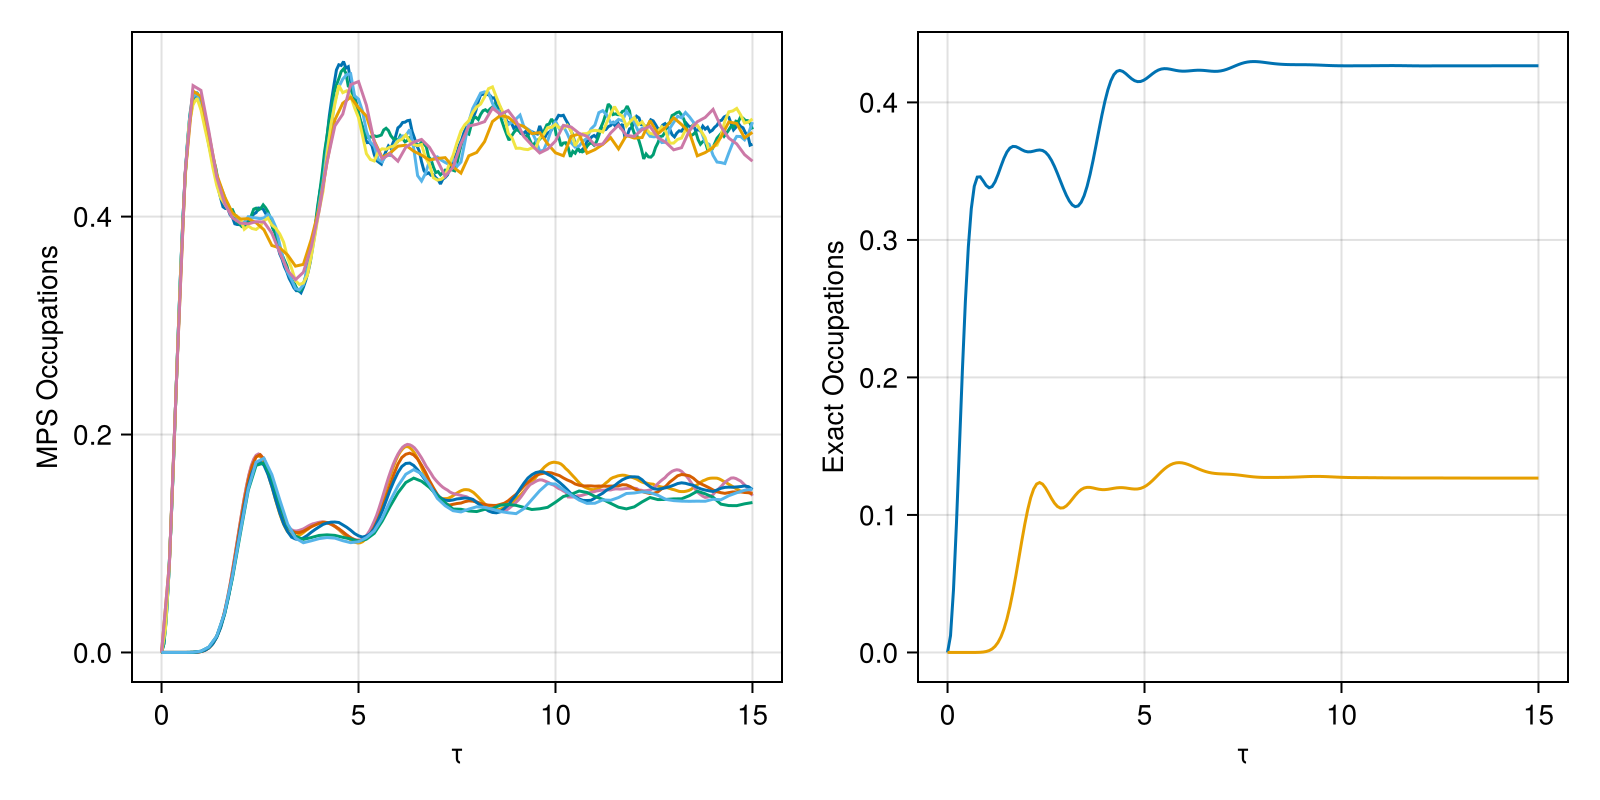

In [16]:
f = Figure(size = (800, 400))

ax1 = Axis(f[1, 1],xlabel="τ", ylabel="MPS Occupations")
ax2 = Axis(f[1, 2],xlabel="τ", ylabel="Exact Occupations")
nfiles = length(file_list)
for i in 2:nfiles

    meta_data, occupations, entropies, bond_dims, correlations, a_ops = read_tn_data(data_route * file_list[i])
    
    time_list = 0.0:meta_data["delta_t"]:meta_data["maxt"]
    lines!(ax1, time_list, occupations[1,1:end])
    lines!(ax1, time_list, occupations[end,1:end])

end

lines!(ax2, tlist, real(result.expect[1,1:end]))
lines!(ax2, tlist, real(result.expect[2,1:end]))

f

In [24]:
println(file_list[5])

meta_data, occupations, entropies, bond_dims, correlations, a_ops = read_tn_data(data_route * file_list[7])
time_list = 0.0:meta_data["delta_t"]:meta_data["maxt"]
tot_oc = sum(occupations, dims=1)[1:end];

TEBD_N3_L6_om2.50_J2.00_gamma1.00_kerr0.10_drive1.50_maxt15.00_deltat0.10_traj100_cutexp-20.h5


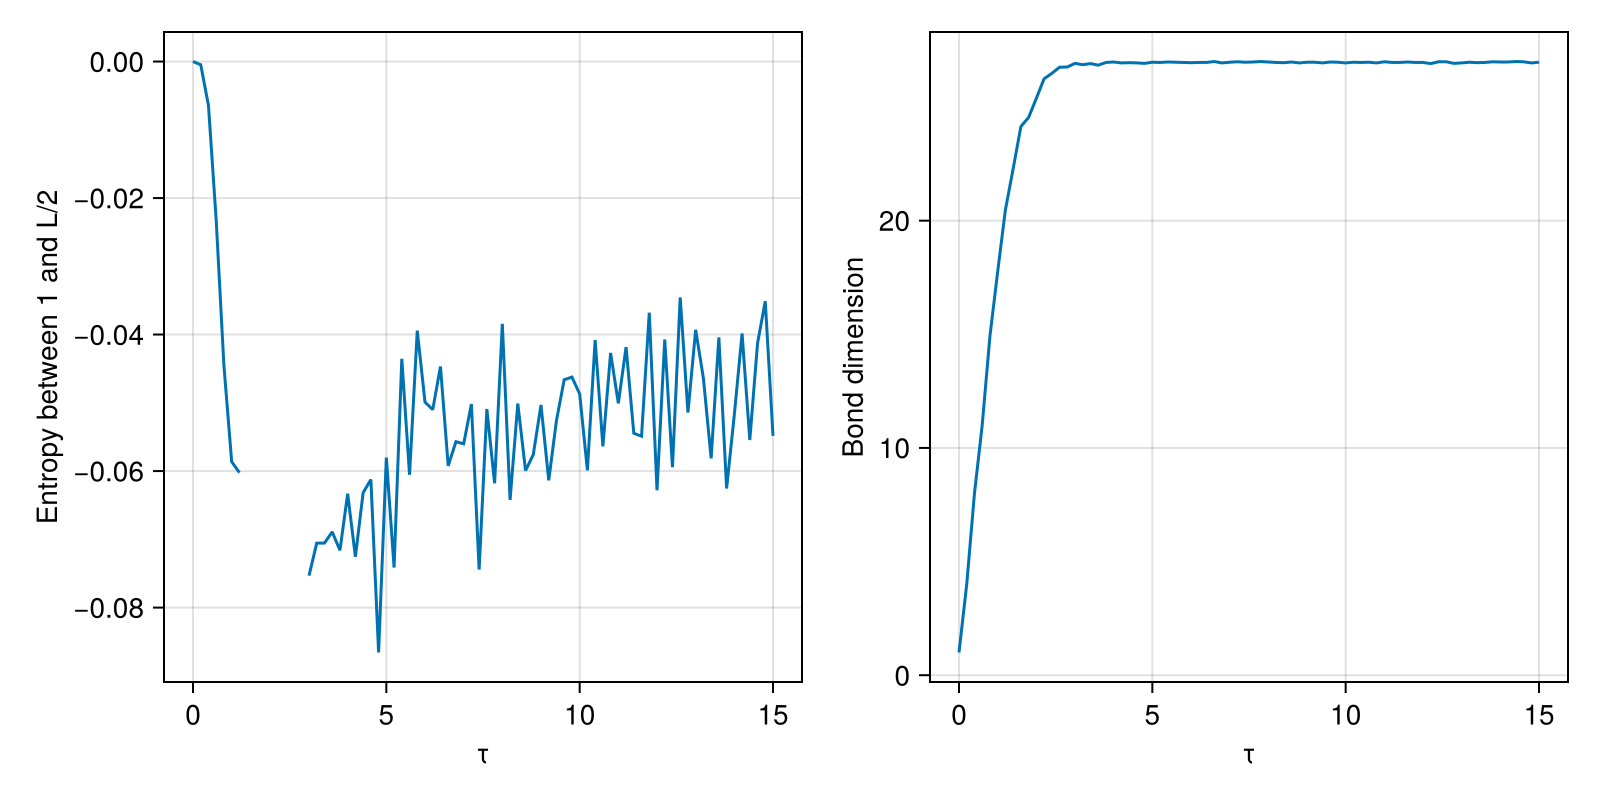

In [25]:
f= Figure(size = (800, 400))
ax1 = Axis(f[1, 1], xlabel="τ", ylabel="Entropy between 1 and L/2")
ax2 = Axis(f[1, 2], xlabel="τ", ylabel="Bond dimension")


lines!(ax1, time_list, entropies)
lines!(ax2, time_list, bond_dims)

f

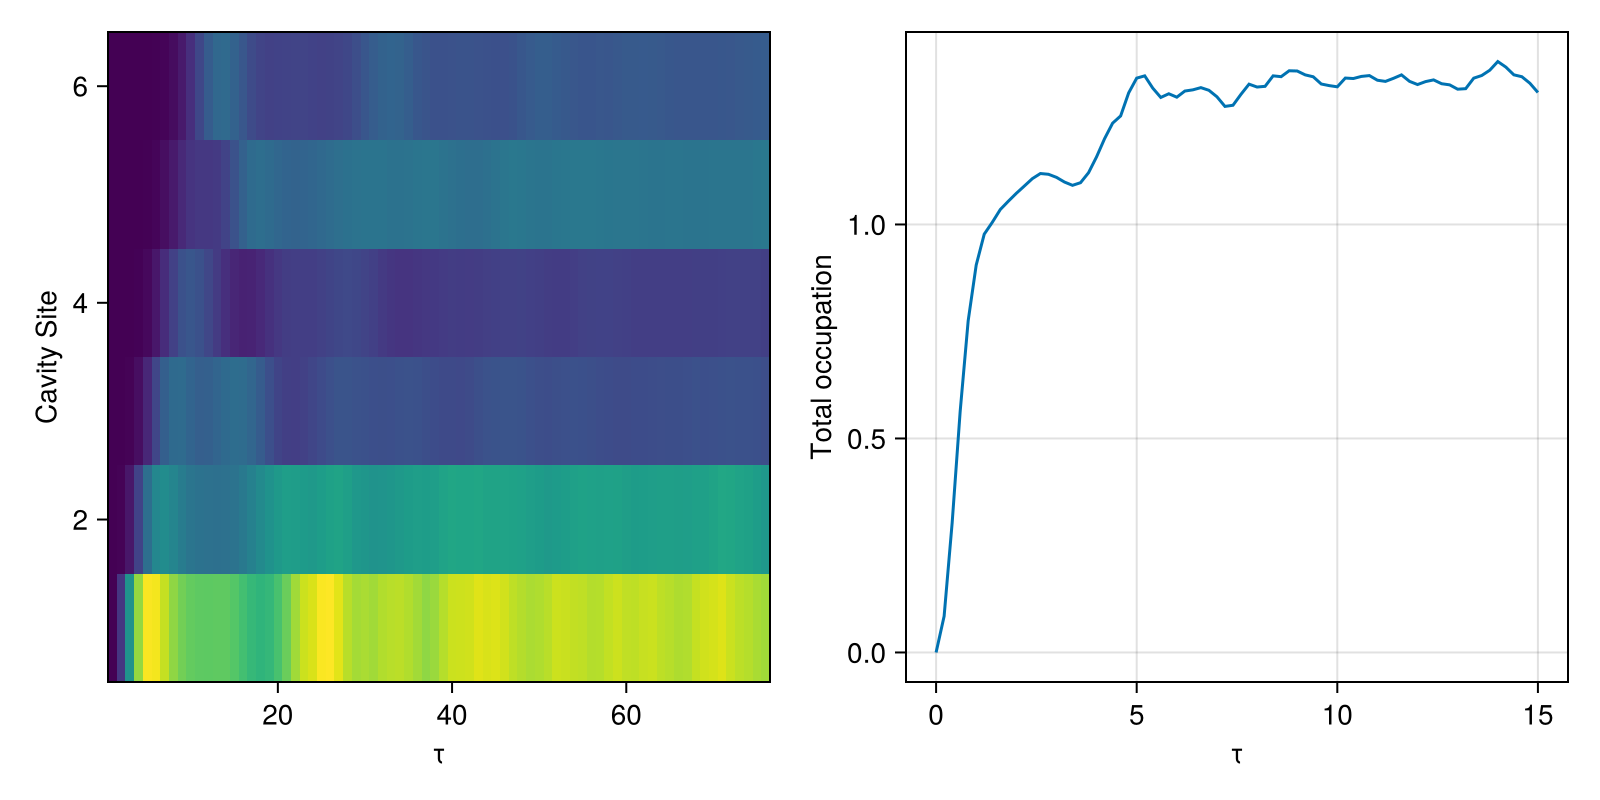

In [28]:
f = Figure(size = (800, 400))
ax1 = Axis(f[1, 1], xlabel="τ", ylabel="Cavity Site")
ax2 = Axis(f[1, 2], xlabel="τ", ylabel="Total occupation")

heatmap!(ax1, transpose(occupations))
lines!(ax2, time_list, tot_oc)
f

In [29]:
# don0t forget the normalziattion factor
tindex = 10
Ct1 = correlations[1,1:end,tindex]/sqrt(correlations[1,1,tindex]*correlations[end,end,tindex])
Ctf = correlations[1,1:end,end]/sqrt(correlations[1,1,end]*correlations[end,end,end])


6-element Vector{ComplexF64}:
   1.7338981908230908 + 1.114657899321425e-17im
  -0.8637849889522924 + 0.8975683475861325im
 0.030313234663161014 - 0.7354608005062734im
      0.6176875627443 + 0.07781079822030001im
  -0.8022964131301081 + 0.49374758675259356im
   0.5371152952184322 - 0.4952729913884611im

In [63]:
# first index is configuration, second time, third lattice site
# grab the value of each configuration at a given lattice site ffor lonf times
a_first = []
a_middle = []
a_last = []

for traj in 1:meta_data["N_trajectories"]
    for time_i in 0:10
        push!(a_first, a_ops[traj,end-time_i,1])
       push!(a_middle, a_ops[traj, end-time_i, round(Int64, meta_data["L"]/2)])
        push!(a_last, a_ops[traj, end-time_i, end])
    end
end

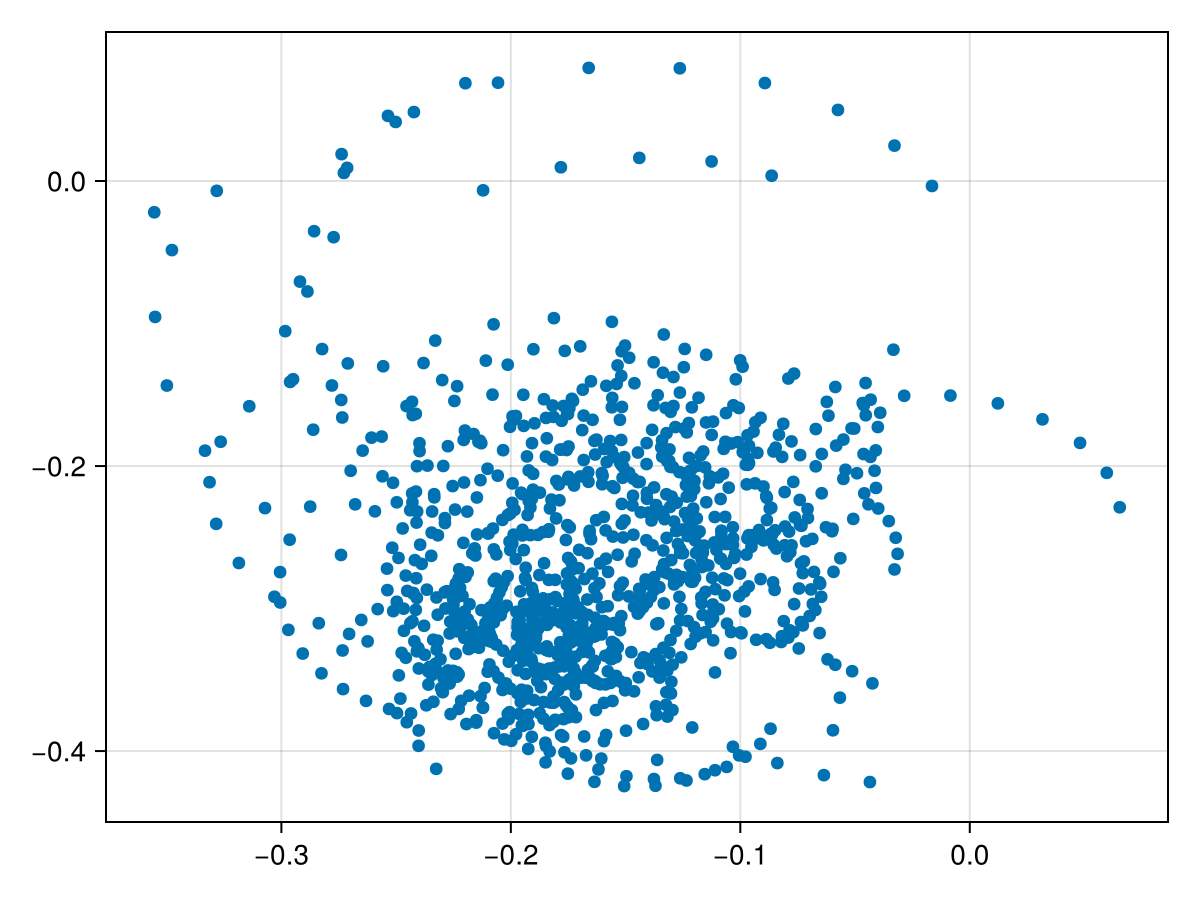

In [64]:
scatter(real(a_middle), imag(a_middle))

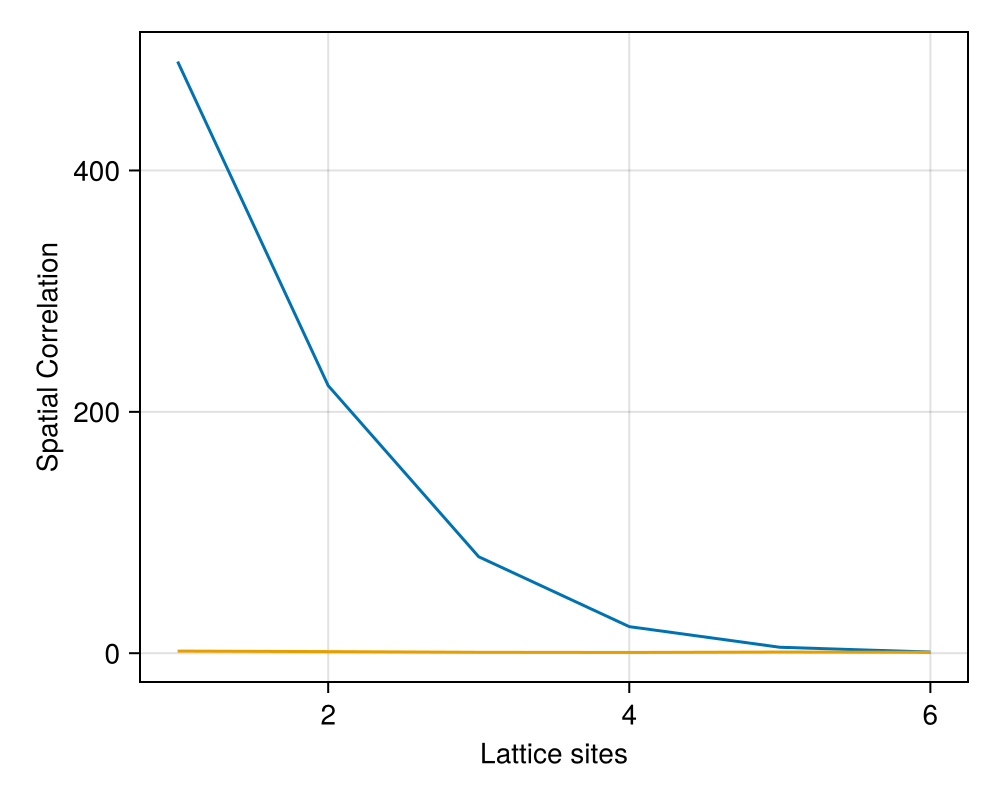

In [65]:
f = Figure(size = (500, 400))
ax1 = Axis(f[1, 1], xlabel="Lattice sites", ylabel="Spatial Correlation")

lines!(abs.(Ct1))
lines!(abs.(Ctf))

f